In [1]:
# Install required packages
!pip install -q kagglehub librosa

# Import necessary libraries
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GRU, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from IPython.display import Audio
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Mount Google Drive (optional)
from google.colab import drive
drive.mount('/content/drive')

# Download dataset using kagglehub
import kagglehub
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to dataset files:", path)

# Since it's already a directory, we'll use it directly
dataset_path = path
print(f"Contents of dataset directory: {os.listdir(dataset_path)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio
Contents of dataset directory: ['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'audio_speech_actors_01-24', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [10]:
# Dataset exploration with recursive file search and proper label extraction
dataset_path = '/kaggle/input/ravdess-emotional-speech-audio'

# Find all .wav files in all subdirectories
audio_files = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith('.wav'):
            audio_files.append(os.path.join(root, file))

print(f"Found {len(audio_files)} audio files")

# Verify we found files
if len(audio_files) == 0:
    raise ValueError("No audio files found! Check dataset path and structure.")

# RAVDESS emotion labels
emotion_labels = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Play a sample audio file with its label
sample_audio = audio_files[0]
print("Sample filename:", os.path.basename(sample_audio))
display(Audio(sample_audio))

Found 2880 audio files
Sample filename: 03-01-08-01-01-01-02.wav


In [11]:
def extract_features(file_path):
    try:
        # Load audio file
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_processed = np.mean(mfccs.T, axis=0)

        # Extract chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_processed = np.mean(chroma.T, axis=0)

        # Extract mel spectrogram features
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_processed = np.mean(mel.T, axis=0)

        # Extract spectral contrast
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
        contrast_processed = np.mean(contrast.T, axis=0)

        # Extract tonnetz features
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sample_rate)
        tonnetz_processed = np.mean(tonnetz.T, axis=0)

        # Combine all features
        features = np.hstack([mfccs_processed, chroma_processed, mel_processed,
                            contrast_processed, tonnetz_processed])

    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}")
        return None

    return features

In [13]:
# Modified feature extraction with better error handling
def extract_features(file_path):
    try:
        # Load audio file with more robust parameters
        audio, sample_rate = librosa.load(file_path,
                                        sr=None,  # Keep original sample rate
                                        mono=True,  # Convert to mono if needed
                                        res_type='kaiser_fast',
                                        duration=3.0)  # Limit duration to handle variable lengths

        # Extract features with error handling
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_processed = np.mean(mfccs.T, axis=0)

        # Chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_processed = np.mean(chroma.T, axis=0)

        # Mel Spectrogram
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_processed = np.mean(librosa.power_to_db(mel).T, axis=0)

        # Spectral Contrast
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
        contrast_processed = np.mean(contrast.T, axis=0)

        # Tonnetz
        y_harmonic = librosa.effects.harmonic(audio)
        tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sample_rate)
        tonnetz_processed = np.mean(tonnetz.T, axis=0)

        # Combine all features
        features = np.hstack([mfccs_processed, chroma_processed, mel_processed,
                            contrast_processed, tonnetz_processed])

        # Verify feature dimensions
        if np.isnan(features).any() or np.isinf(features).any():
            raise ValueError("Invalid feature values detected")

        return features

    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {str(e)}")
        return None

# Extract features and labels from all audio files
features = []
labels = []
failed_files = []

for file_path in tqdm(audio_files, desc="Extracting features"):
    # Get emotion label from filename
    try:
        file_name = os.path.basename(file_path)
        emotion_code = file_name.split("-")[2]
        emotion = emotion_labels[emotion_code]

        # Extract features
        feature = extract_features(file_path)

        if feature is not None:
            features.append(feature)
            labels.append(emotion)
        else:
            failed_files.append(file_path)
    except Exception as e:
        print(f"Skipping {file_name}: {str(e)}")
        failed_files.append(file_path)

# Convert to numpy arrays
if len(features) > 0:
    X = np.array(features)
    y = np.array(labels)
    print(f"\nSuccessfully processed {len(features)} files")
    print(f"Failed to process {len(failed_files)} files")
else:
    raise ValueError("No features extracted - check audio files and paths")

Extracting features: 100%|██████████| 2880/2880 [29:33<00:00,  1.62it/s]


Successfully processed 2880 files
Failed to process 0 files


In [45]:
# Verify we have data
if len(y) == 0:
    raise ValueError("No labels found! Check label extraction process.")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split dataset FIRST
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=y_encoded)

# Initialize scaler
scaler = StandardScaler()

# Fit ONLY on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using training parameters
X_test_scaled = scaler.transform(X_test)

# Reshape for GRU/Transformer input
X_train_reshaped = np.expand_dims(X_train_scaled, axis=1)
X_test_reshaped = np.expand_dims(X_test_scaled, axis=1)

print(f"\nFinal shapes:")
print(f"Training set: {X_train_reshaped.shape}")
print(f"Test set: {X_test_reshaped.shape}")
print(f"Training labels: {y_train.shape}")
print(f"Test labels: {y_test.shape}")


Final shapes:
Training set: (2304, 1, 193)
Test set: (576, 1, 193)
Training labels: (2304, 8)
Test labels: (576, 8)


In [46]:
from keras.layers import Input, GRU, Bidirectional, Dropout, Dense
from keras.models import Model

def build_gru_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(GRU(128, return_sequences=False))(inputs)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

from keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D, MultiHeadAttention
from keras.models import Model

def build_transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = MultiHeadAttention(num_heads=2, key_dim=64)(x, x)
    x = Dropout(0.1)(attn_output)
    x = Dense(128, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model


In [47]:
def train_and_evaluate(model, optimizer, name):
    print(f"\n🚀 Training {name} ...")
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(
        X_train_reshaped, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=1
    )
    loss, acc = model.evaluate(X_test_reshaped, y_test, verbose=0)
    print(f"✅ {name} Test Accuracy: {acc:.4f}")
    return acc, history


In [48]:
results = {}
histories = {}

gru_adam = build_gru_model(X_train_reshaped.shape[1:], y_train.shape[1])
results['GRU + Adam'], histories['GRU + Adam'] = train_and_evaluate(gru_adam, Adam(), 'GRU + Adam')

gru_rmsprop = build_gru_model(X_train_reshaped.shape[1:], y_train.shape[1])
results['GRU + RMSprop'], histories['GRU + RMSprop'] = train_and_evaluate(gru_rmsprop, RMSprop(), 'GRU + RMSprop')

trans_adam = build_transformer_model(X_train_reshaped.shape[1:], y_train.shape[1])
results['Transformer + Adam'], histories['Transformer + Adam'] = train_and_evaluate(trans_adam, Adam(), 'Transformer + Adam')

trans_rmsprop = build_transformer_model(X_train_reshaped.shape[1:], y_train.shape[1])
results['Transformer + RMSprop'], histories['Transformer + RMSprop'] = train_and_evaluate(trans_rmsprop, RMSprop(), 'Transformer + RMSprop')



🚀 Training GRU + Adam ...
Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2519 - loss: 1.9000 - val_accuracy: 0.3810 - val_loss: 1.6205 - learning_rate: 0.0010
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3900 - loss: 1.5902 - val_accuracy: 0.4156 - val_loss: 1.4397 - learning_rate: 0.0010
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4681 - loss: 1.4162 - val_accuracy: 0.5065 - val_loss: 1.2825 - learning_rate: 0.0010
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5358 - loss: 1.2814 - val_accuracy: 0.5238 - val_loss: 1.1677 - learning_rate: 0.0010
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5414 - loss: 1.2538 - val_accuracy: 0.6190 - val_loss: 1.0999 - learning_rate: 0.0010
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5863 - loss: 1.1150 - val_accuracy: 0.5801 - val_loss: 1.0484 - learning_rate: 0.0010
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6183 - l

In [49]:
# Show results in table
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Test Accuracy"])
results_df = results_df.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)
results_df.style.bar(subset=["Test Accuracy"], color='skyblue').format({"Test Accuracy": "{:.4f}"})


,Model,Test Accuracy
0,GRU + Adam,0.8872
1,GRU + RMSprop,0.8872
2,Transformer + Adam,0.8785
3,Transformer + RMSprop,0.8698


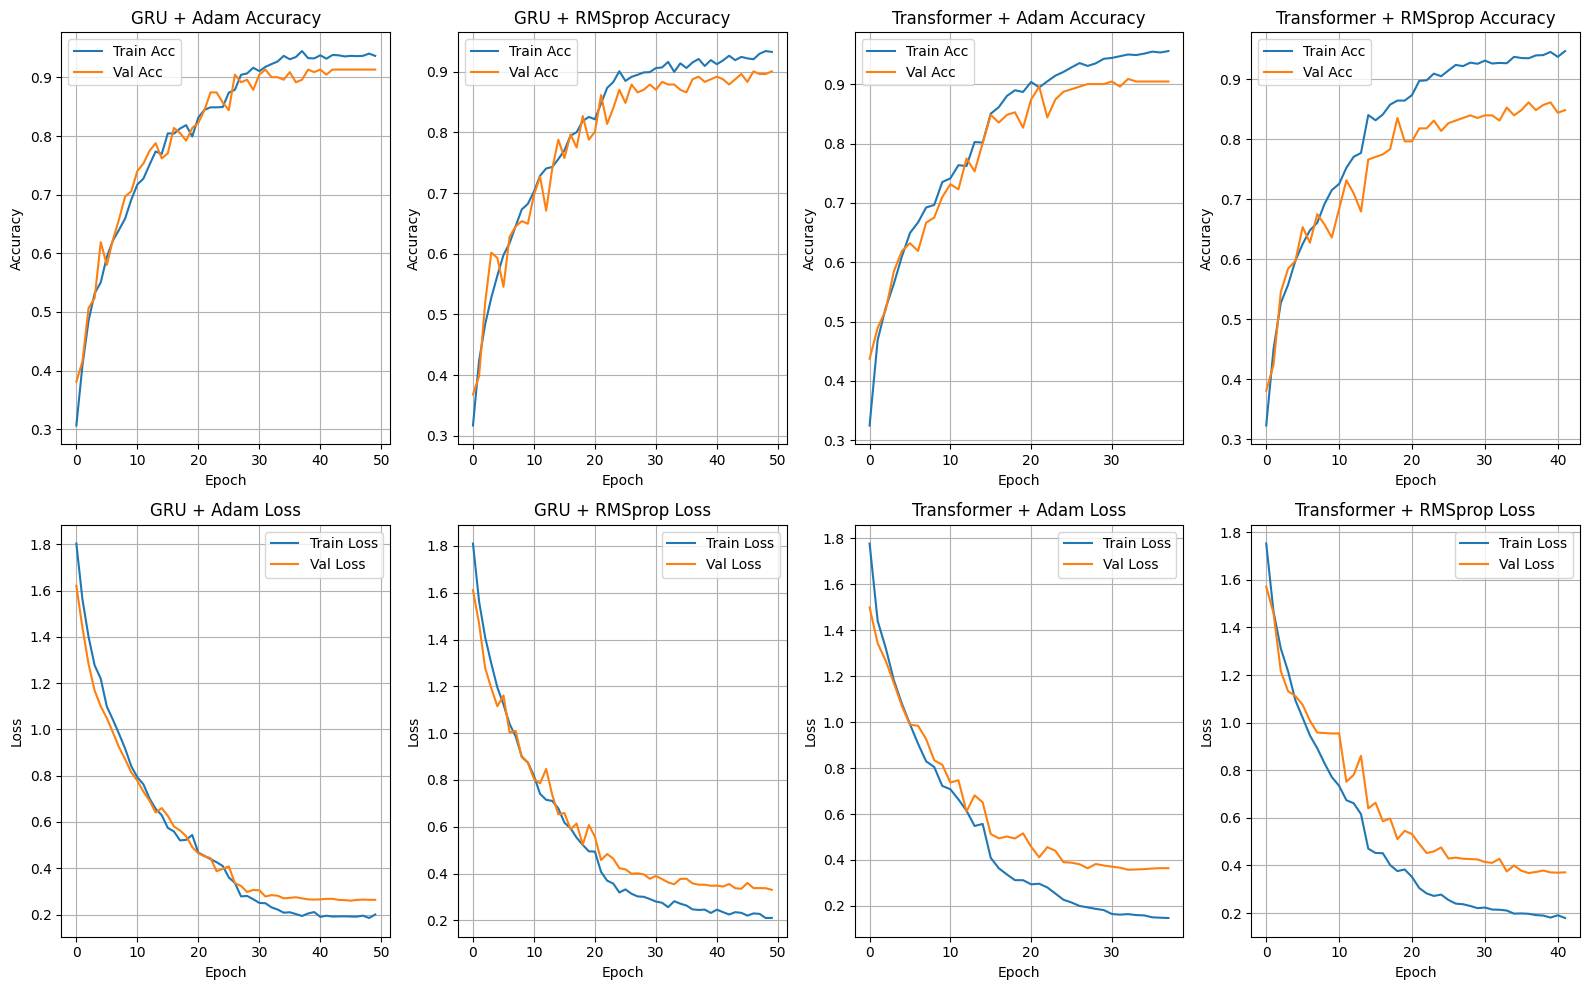

In [50]:
import matplotlib.pyplot as plt

def plot_all_histories(histories):
    plt.figure(figsize=(16, 10))

    for i, (name, history) in enumerate(histories.items()):
        # Accuracy
        plt.subplot(2, 4, i + 1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f'{name} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Loss
        plt.subplot(2, 4, i + 5)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'{name} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_all_histories(histories)


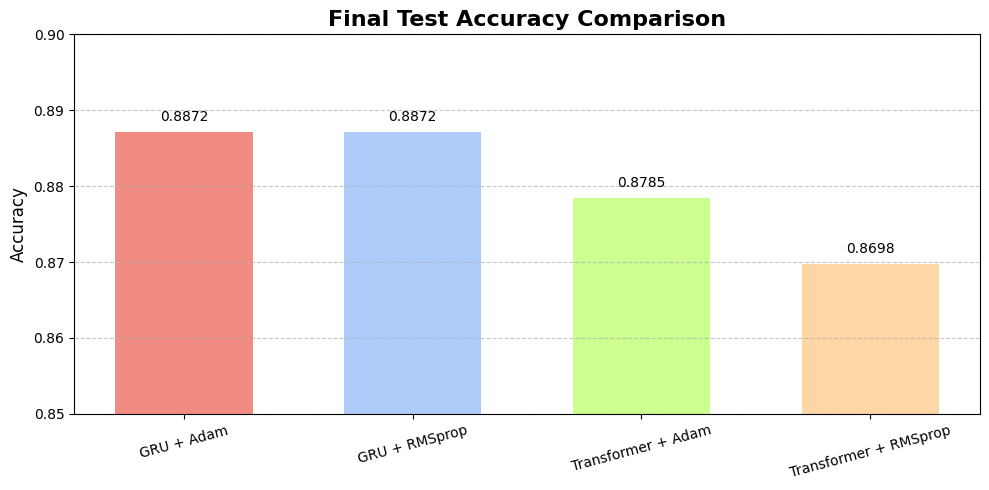

In [52]:
import matplotlib.pyplot as plt

def plot_accuracy_bars(results_dict):
    names = list(results_dict.keys())
    accuracies = [results_dict[name] for name in names]

    # Set up the figure
    plt.figure(figsize=(10, 5))
    bars = plt.bar(names, accuracies, color=['#f28b82', '#aecbfa', '#ccff90', '#ffd6a5'], width=0.6)

    # Titles and labels
    plt.title('Final Test Accuracy Comparison', fontsize=16, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(rotation=15, fontsize=10)
    plt.ylim(0.85, 0.90)  # Adjusted to tightly zoom on values

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.001, f'{acc:.4f}', ha='center', va='bottom', fontsize=10)

    # Grid and layout
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_accuracy_bars(results)


In [53]:
# Save model
gru_adam.save("best_gru_model.h5")
print("✅ Model saved as best_gru_model.h5")


✅ Model saved as best_gru_model.h5


In [54]:
import joblib

# Example: Save the StandardScaler or preprocessing steps
joblib.dump(scaler, "preprocessing_scaler.pkl")
print("✅ Scaler saved.")


✅ Scaler saved.
